In [1]:
from pandas import read_csv

tagged = dict([(p,w) for _,p,w in read_csv('../input/whale-categorization-playground/train.csv').to_records()])
submit = [p for _,p,_ in read_csv('../input/whale-categorization-playground/sample_submission.csv').to_records()]
join   = list(tagged.keys()) + submit
len(tagged),len(submit),len(join),list(tagged.items())[:5],submit[:5]

(9850,
 15610,
 25460,
 [('00022e1a.jpg', 'w_e15442c'),
  ('000466c4.jpg', 'w_1287fbc'),
  ('00087b01.jpg', 'w_da2efe0'),
  ('001296d5.jpg', 'w_19e5482'),
  ('0014cfdf.jpg', 'w_f22f3e3')],
 ['00029b3a.jpg',
  '0003c693.jpg',
  '000bc353.jpg',
  '0010a672.jpg',
  '00119c3f.jpg'])

In [2]:
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

def expand_path(p):
    if isfile('../input/whale-categorization-playground/train/' + p): return '../input/whale-categorization-playground/train/' + p
    if isfile('../input/whale-categorization-playground/test/' + p): return '../input/whale-categorization-playground/test/' + p
    return p

p2size = {}
for p in tqdm_notebook(join):
    size      = pil_image.open(expand_path(p)).size
    p2size[p] = size
len(p2size), list(p2size.items())[:5]

A Jupyter Widget

(25460,
 [('00022e1a.jpg', (699, 500)),
  ('000466c4.jpg', (1050, 700)),
  ('00087b01.jpg', (1050, 368)),
  ('001296d5.jpg', (397, 170)),
  ('0014cfdf.jpg', (700, 398))])

In [3]:
import pickle
import numpy as np
from imagehash import phash
from math import sqrt
def match(h1,h2):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 =  pil_image.open(expand_path(p1))
            i2 =  pil_image.open(expand_path(p2))
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1/sqrt((a1**2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2/sqrt((a2**2).mean())
            a  = ((a1 - a2)**2).mean()
            if a > 0.1: return False
    return True

if isfile('../input/humpback-whale-identification-model-files/p2h.pickle'):
    with open('../input/humpback-whale-identification-model-files/p2h.pickle', 'rb') as f:
        p2h = pickle.load(f)
else:
    p2h = {}
    for p in tqdm_notebook(join):
        img    = pil_image.open(expand_path(p))
        h      = phash(img)
        p2h[p] = h
    h2ps = {}
    for p,h in p2h.items():
        if h not in h2ps: h2ps[h] = []
        if p not in h2ps[h]: h2ps[h].append(p)
    hs = list(h2ps.keys())
    h2h = {}
    for i,h1 in enumerate(tqdm_notebook(hs)):
        for h2 in hs[:i]:
            if h1-h2 <= 6 and match(h1, h2):
                s1 = str(h1)
                s2 = str(h2)
                if s1 < s2: s1,s2 = s2,s1
                h2h[s1] = s2
    for p,h in p2h.items():
        h = str(h)
        if h in h2h: h = h2h[h]
        p2h[p] = h

len(p2h), list(p2h.items())[:5]

(25460,
 [('00022e1a.jpg', 'b362cc79b1a623b8'),
  ('000466c4.jpg', 'b3cccc3331cc8733'),
  ('00087b01.jpg', 'bc4ed0f2a7e168a8'),
  ('001296d5.jpg', '93742d9a28b35b87'),
  ('0014cfdf.jpg', 'd4a1dab1c49f6352')])

In [4]:
h2ps = {}
for p,h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)
len(h2ps),list(h2ps.items())[:5]

(20913,
 [('b362cc79b1a623b8', ['00022e1a.jpg']),
  ('b3cccc3331cc8733', ['000466c4.jpg']),
  ('bc4ed0f2a7e168a8', ['00087b01.jpg', '7c72d707.jpg']),
  ('93742d9a28b35b87', ['001296d5.jpg']),
  ('d4a1dab1c49f6352', ['0014cfdf.jpg', '89c94943.jpg'])])

Images: ['0c35fcb4.jpg', '2d6610b9.jpg', 'a98bfd97.jpg']


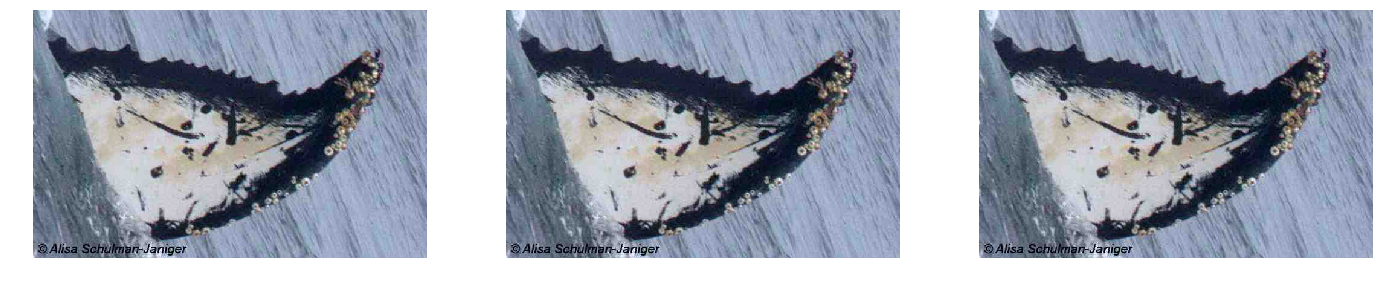

In [5]:
import matplotlib.pyplot as plt

def show_whale(imgs, per_row=2):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

for h, ps in h2ps.items():
    if len(ps) > 2:
        print('Images:', ps)
        imgs = [pil_image.open(expand_path(p)) for p in ps]
        show_whale(imgs, per_row=len(ps))
        break

In [6]:
def prefer(ps):
    if len(ps) == 1: return ps[0]
    best_p = ps[0]
    best_s = p2size[best_p]
    for i in range(1, len(ps)):
        p = ps[i]
        s = p2size[p]
        if s[0]*s[1] > best_s[0]*best_s[1]: 
            best_p = p
            best_s = s
    return best_p

h2p = {}
for h,ps in h2ps.items(): h2p[h] = prefer(ps)
len(h2p),list(h2p.items())[:5]

(20913,
 [('b362cc79b1a623b8', '00022e1a.jpg'),
  ('b3cccc3331cc8733', '000466c4.jpg'),
  ('bc4ed0f2a7e168a8', '00087b01.jpg'),
  ('93742d9a28b35b87', '001296d5.jpg'),
  ('d4a1dab1c49f6352', '0014cfdf.jpg')])

In [7]:
with open('../input/humpback-whale-identification-model-files/rotate.txt', 'rt') as f: rotate = f.read().split('\n')[:-1]
rotate = set(rotate)
rotate

{'2b792814.jpg',
 '2bc459eb.jpg',
 '3401bafe.jpg',
 '56fafc52.jpg',
 'a492ab72.jpg',
 'd1502267.jpg',
 'e53d2b96.jpg',
 'ed4f0cd5.jpg',
 'f2ec136c.jpg',
 'f966c073.jpg'}

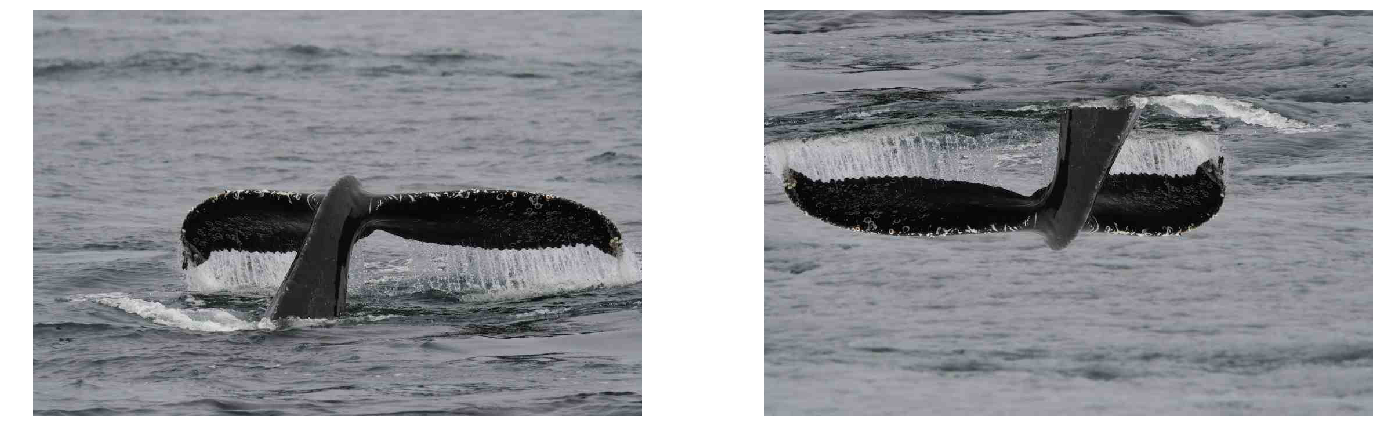

In [8]:
def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    if p in rotate: img = img.rotate(180)
    return img

p    = list(rotate)[0]
imgs = [pil_image.open(expand_path(p)), read_raw_image(p)]
show_whale(imgs)

In [9]:
with open('../input/humpback-whale-identification-model-files/bounding-box.pickle', 'rb') as f:
    p2bb = pickle.load(f)
list(p2bb.items())[:5]

[('00022e1a.jpg', (34, 45, 682, 317)),
 ('000466c4.jpg', (263, 309, 591, 412)),
 ('00087b01.jpg', (-6, 2, 1028, 363)),
 ('001296d5.jpg', (9, 21, 387, 135)),
 ('0014cfdf.jpg', (36, 129, 636, 299))]

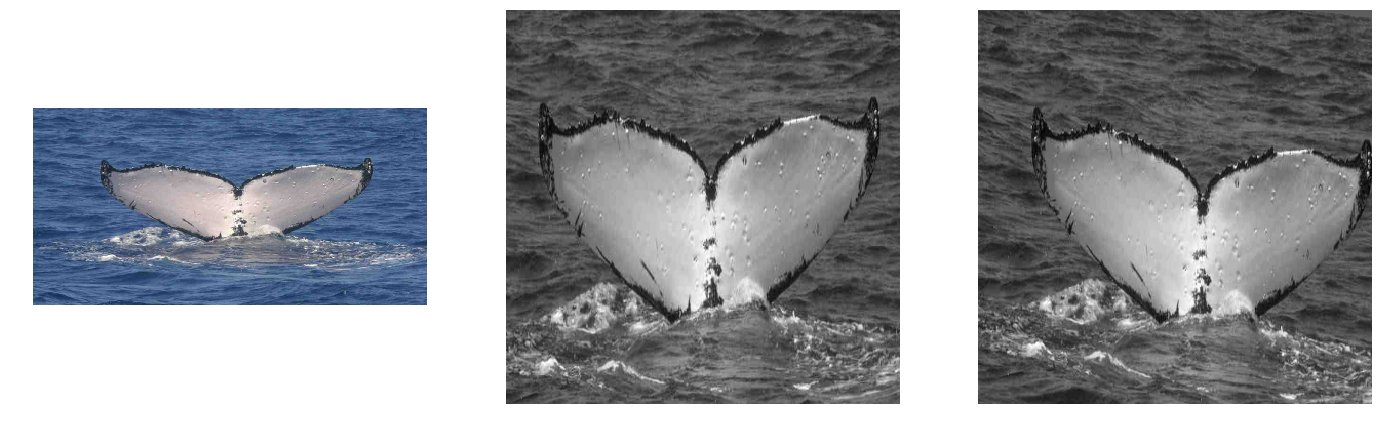

In [10]:
import sys
import platform
old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')
import keras
sys.stderr = old_stderr

import random
from keras import backend as K
from keras.preprocessing.image import img_to_array,array_to_img
from scipy.ndimage import affine_transform

img_shape    = (384,384,1) 
anisotropy   = 2.15 
crop_margin  = 0.05 

def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

def read_cropped_image(p, augment):
    if p in h2p: p = h2p[p]
    size_x,size_y = p2size[p]

    x0,y0,x1,y1   = p2bb[p]
    if p in rotate: x0, y0, x1, y1 = size_x - x1, size_y - y1, size_x - x0, size_y - y0
    dx            = x1 - x0
    dy            = y1 - y0
    x0           -= dx*crop_margin
    x1           += dx*crop_margin + 1
    y0           -= dy*crop_margin
    y1           += dy*crop_margin + 1
    if (x0 < 0     ): x0 = 0
    if (x1 > size_x): x1 = size_x
    if (y0 < 0     ): y0 = 0
    if (y1 > size_y): y1 = size_y
    dx            = x1 - x0
    dy            = y1 - y0
    if dx > dy*anisotropy:
        dy  = 0.5*(dx/anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx  = 0.5*(dy*anisotropy - dx)
        x0 -= dx
        x1 += dx

    trans = np.array([[1, 0, -0.5*img_shape[0]], [0, 1, -0.5*img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0)/img_shape[0], 0, 0], [0, (x1 - x0)/img_shape[1], 0], [0, 0, 1]]), trans)
    if augment:
        trans = np.dot(build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.8, 1.0),
            random.uniform(0.8, 1.0),
            random.uniform(-0.05*(y1 - y0), 0.05*(y1 - y0)),
            random.uniform(-0.05*(x1 - x0), 0.05*(x1 - x0))
            ), trans)
    trans = np.dot(np.array([[1, 0, 0.5*(y1 + y0)], [0, 1, 0.5*(x1 + x0)], [0, 0, 1]]), trans)

    img   = read_raw_image(p).convert('L')
    img   = img_to_array(img)
    
    matrix = trans[:2,:2]
    offset = trans[:2,2]
    img    = img.reshape(img.shape[:-1])
    img    = affine_transform(img, matrix, offset, output_shape=img_shape[:-1], order=1, mode='constant', cval=np.average(img))
    img    = img.reshape(img_shape)

    img  -= np.mean(img, keepdims=True)
    img  /= np.std(img, keepdims=True) + K.epsilon()
    return img

def read_for_training(p):
    return read_cropped_image(p, True)

def read_for_validation(p):
  
    return read_cropped_image(p, False)

p = list(tagged.keys())[312]
imgs = [
    read_raw_image(p),
    array_to_img(read_for_validation(p)),
    array_to_img(read_for_training(p))
]
show_whale(imgs, per_row=3)

In [11]:
from keras import regularizers
from keras.optimizers import Adam
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, Lambda, MaxPooling2D, Reshape
from keras.models import Model

def subblock(x, filter, **kwargs):
    x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y) 
    y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y) 
    y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y)
    y = Add()([x,y]) 
    y = Activation('relu')(y)
    return y

def build_model(lr, l2, activation='sigmoid'):

    regul  = regularizers.l2(l2)
    optim  = Adam(lr=lr)
    kwargs = {'padding':'same', 'kernel_regularizer':regul}

    inp = Input(shape=img_shape) 
    x   = Conv2D(64, (9,9), strides=2, activation='relu', **kwargs)(inp)

    x   = MaxPooling2D((2, 2), strides=(2, 2))(x) 
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3,3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) 
    x = BatchNormalization()(x)
    x = Conv2D(128, (1,1), activation='relu', **kwargs)(x)
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) 
    x = BatchNormalization()(x)
    x = Conv2D(256, (1,1), activation='relu', **kwargs)(x)
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) 
    x = BatchNormalization()(x)
    x = Conv2D(384, (1,1), activation='relu', **kwargs)(x) 
    for _ in range(4): x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) 
    x = BatchNormalization()(x)
    x = Conv2D(512, (1,1), activation='relu', **kwargs)(x) 
    for _ in range(4): x = subblock(x, 128, **kwargs)
    
    x             = GlobalMaxPooling2D()(x) 
    branch_model  = Model(inp, x)
    
    mid        = 32
    xa_inp     = Input(shape=branch_model.output_shape[1:])
    xb_inp     = Input(shape=branch_model.output_shape[1:])
    x1         = Lambda(lambda x : x[0]*x[1])([xa_inp, xb_inp])
    x2         = Lambda(lambda x : x[0] + x[1])([xa_inp, xb_inp])
    x3         = Lambda(lambda x : K.abs(x[0] - x[1]))([xa_inp, xb_inp])
    x4         = Lambda(lambda x : K.square(x))(x3)
    x          = Concatenate()([x1, x2, x3, x4])
    x          = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    x          = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
    x          = Reshape((branch_model.output_shape[1], mid, 1))(x)
    x          = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
    x          = Flatten(name='flatten')(x)
    
    x          = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')

    img_a      = Input(shape=img_shape)
    img_b      = Input(shape=img_shape)
    xa         = branch_model(img_a)
    xb         = branch_model(img_b)
    x          = head_model([xa, xb])
    model      = Model([img_a, img_b], x)
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model

model, branch_model, head_model = build_model(64e-5,0)
head_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512)          0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_2[0][0]                    
          

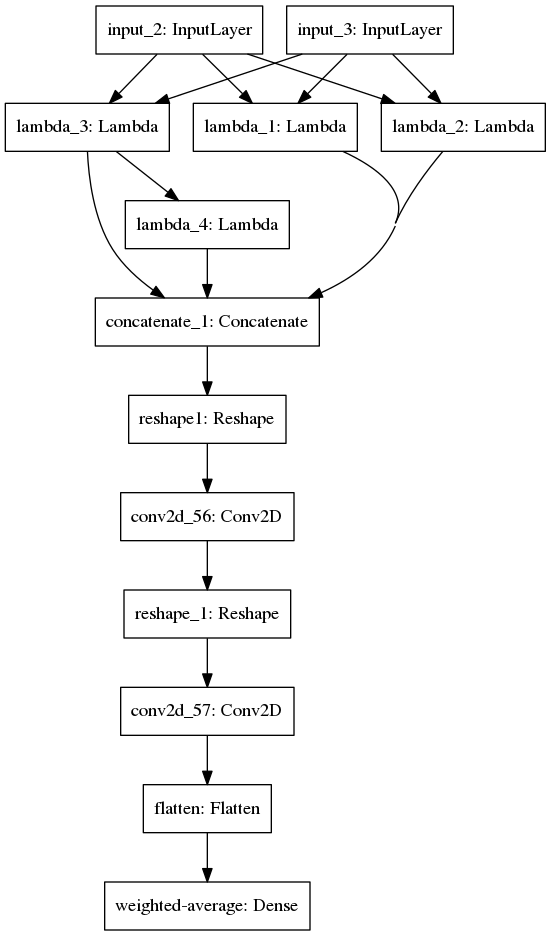

In [12]:
from keras.utils import plot_model
plot_model(head_model, to_file='head-model.png')
pil_image.open('head-model.png')

In [13]:
branch_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 64) 5248        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 96, 96, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 64)   256         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_2 (

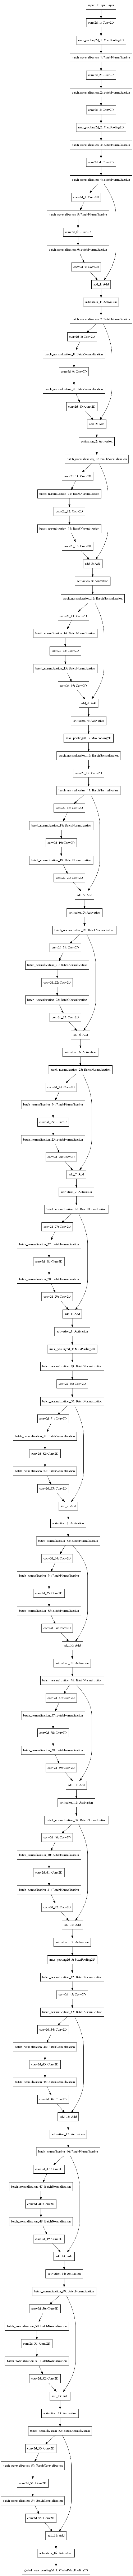

In [14]:
plot_model(branch_model, to_file='branch-model.png')
img = pil_image.open('branch-model.png')
img.resize([x//2 for x in img.size])

In [15]:
with open('../input/humpback-whale-identification-model-files/exclude.txt', 'rt') as f: exclude = f.read().split('\n')[:-1]   
len(exclude)

34

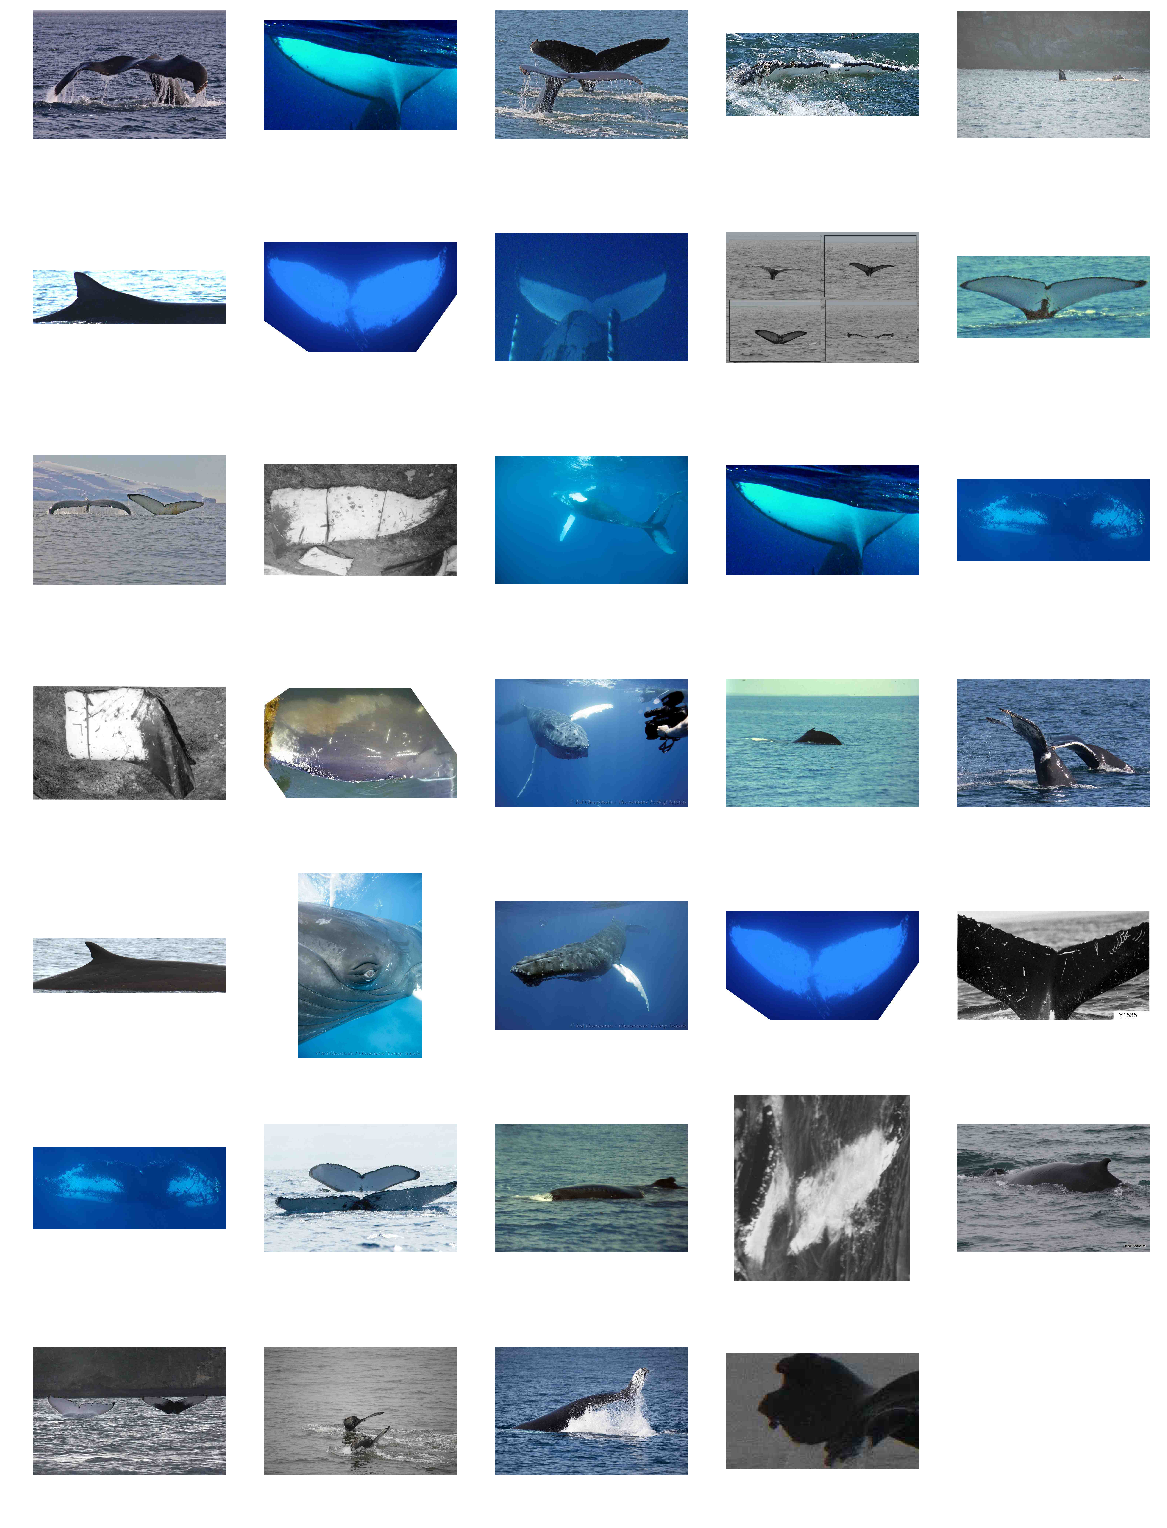

In [16]:
show_whale([read_raw_image(p) for p in exclude], per_row=5)

In [17]:
h2ws = {}
new_whale = 'new_whale'
for p,w in tagged.items():
    if w != new_whale:
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h,ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)
len(h2ws)

8412

In [18]:
w2hs = {}
for h,ws in h2ws.items():
    if len(ws) == 1: 
        if h2p[h] in exclude:
            print(h) 
        else:
            w = ws[0]
            if w not in w2hs: w2hs[w] = []
            if h not in w2hs[w]: w2hs[w].append(h)
for w,hs in w2hs.items():
    if len(hs) > 1:
        w2hs[w] = sorted(hs)
len(w2hs)

ebf094854a2bb1d6
f86bcf9487653848
d931c4768ebf9098
807b19b6766d09ce
bc984f67a31b48a6
aa557d0ad40f807f
c5313ec3c0343bcf
9dc39bb4833cc3c8
fb8c85f18c67131c
afa994d4416b2ab6
c0352f2194b7fcca
c4cc196f46bc8cce
c0c0753e9fcf4368
e5d11a1e86c47979
cdc0363cc23c3ecb
d8dc91b13fae8a18
f3ad8c8cb2b38c8c
f18c966fb836c90c
f8908e4ee223f758
a2d5d5eae64f2a01
96c949b632e90d3e
88d1a0eee07ce9da
e8d1960f60b13fca
d08f9d61729e8d61
90376cc843f6b9a3
e92d90d2616f0f9c
c96d1296e96b16b4
c7882c3359ec7327
9467679c9b638c98
f43183739a8f53c4


4239

In [19]:
train = [] 
for hs in w2hs.values():
    if len(hs) > 1:
        train += hs
random.shuffle(train)
train_set = set(train)

w2ts = {} 
for w,hs in w2hs.items():
    for h in hs:
        if h in train_set:
            if w not in w2ts: w2ts[w] = []
            if h not in w2ts[w]: w2ts[w].append(h)
for w,ts in w2ts.items(): w2ts[w] = np.array(ts)
    
t2i = {} 
for i,t in enumerate(train): t2i[t] = i

len(train),len(w2ts)

(6038, 1905)

In [20]:
from keras.utils import Sequence
try:
    from lap import lapjv
    segment = False
except ImportError:
    print('Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment')
    segment = True
    from scipy.optimize import linear_sum_assignment

class TrainingData(Sequence):
    def __init__(self, score, steps=1000, batch_size=32):
        super(TrainingData, self).__init__()
        self.score      = -score 
        self.steps      = steps
        self.batch_size = batch_size
        for ts in w2ts.values():
            idxs = [t2i[t] for t in ts]
            for i in idxs:
                for j in idxs:
                    self.score[i,j] = 10000.0 
        self.on_epoch_end()
    def __getitem__(self, index):
        start = self.batch_size*index
        end   = min(start + self.batch_size, len(self.match) + len(self.unmatch))
        size  = end - start
        assert size > 0
        a     = np.zeros((size,) + img_shape, dtype=K.floatx())
        b     = np.zeros((size,) + img_shape, dtype=K.floatx())
        c     = np.zeros((size,1), dtype=K.floatx())
        j     = start//2
        for i in range(0, size, 2):
            a[i,  :,:,:] = read_for_training(self.match[j][0])
            b[i,  :,:,:] = read_for_training(self.match[j][1])
            c[i,  0    ] = 1 
            a[i+1,:,:,:] = read_for_training(self.unmatch[j][0])
            b[i+1,:,:,:] = read_for_training(self.unmatch[j][1])
            c[i+1,0    ] = 0 
            j           += 1
        return [a,b],c
    def on_epoch_end(self):
        if self.steps <= 0: return 
        self.steps     -= 1
        self.match      = []
        self.unmatch    = []
        if segment:
            tmp   = []
            batch = 512
            for start in range(0, score.shape[0], batch):
                end = min(score.shape[0], start + batch)
                _, x = linear_sum_assignment(self.score[start:end, start:end])
                tmp.append(x + start)
            x = np.concatenate(tmp)
        else:
            _,_,x = lapjv(self.score) 
        y = np.arange(len(x),dtype=np.int32)

        for ts in w2ts.values():
            d = ts.copy()
            while True:
                random.shuffle(d)
                if not np.any(ts == d): break
            for ab in zip(ts,d): self.match.append(ab)
        for i,j in zip(x,y):
            if i == j:
                print(self.score)
                print(x)
                print(y)
                print(i,j)
            assert i != j
            self.unmatch.append((train[i],train[j]))
        self.score[x,y] = 10000.0
        self.score[y,x] = 10000.0
        random.shuffle(self.match)
        random.shuffle(self.unmatch)
        assert len(self.match) == len(train) and len(self.unmatch) == len(train)
    def __len__(self):
        return (len(self.match) + len(self.unmatch) + self.batch_size - 1)//self.batch_size

Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment


In [21]:
score = np.random.random_sample(size=(len(train),len(train)))
data = TrainingData(score)
(a, b), c = data[0]
a.shape, b.shape, c.shape

((32, 384, 384, 1), (32, 384, 384, 1), (32, 1))

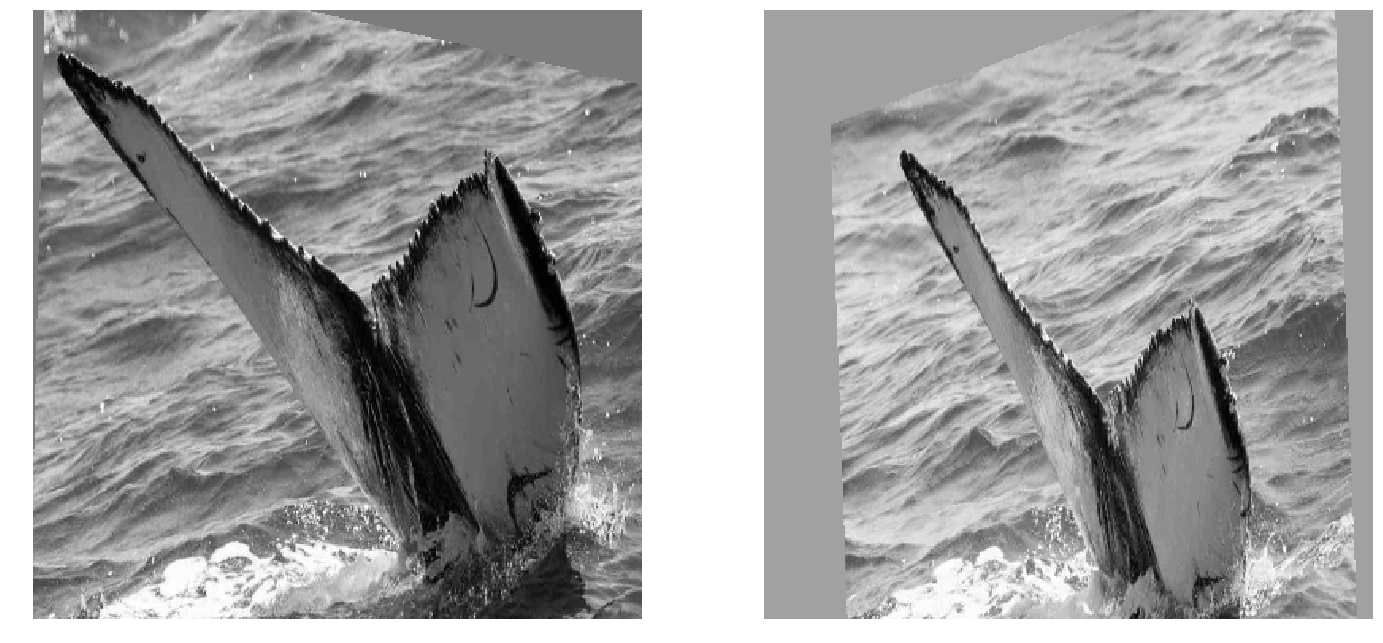

In [22]:
imgs = [array_to_img(a[0]), array_to_img(b[0])]
show_whale(imgs, per_row=2)

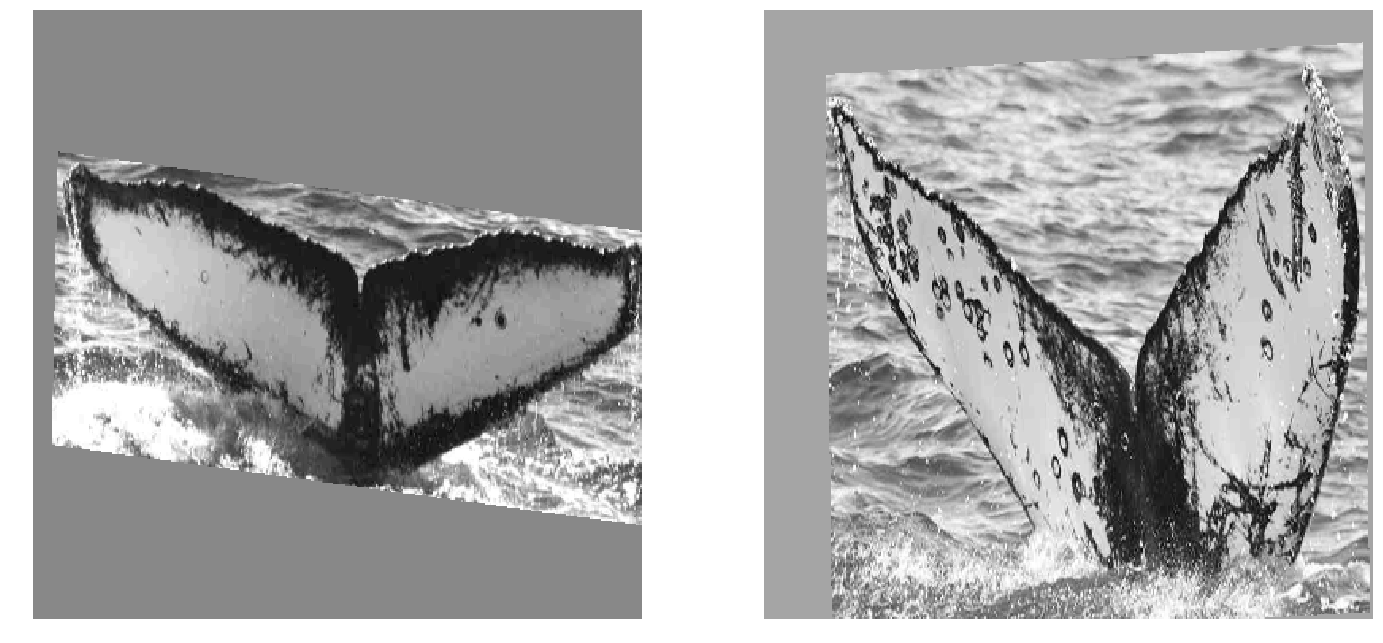

In [23]:
imgs = [array_to_img(a[1]), array_to_img(b[1])]
show_whale(imgs, per_row=2)

The following table shows the exact schedule used for the learning rate (LR), L2 regularization (L2) and randomized score matrix (K). 

Also note that the score matrix for the Linear Assignment Problem is computed at every 5 epochs starting with epoch 10.

Epochs | LR | K | L2
---- | ---: | ---: | ---:
1-10 | \\( 64.10^{-5} \\)  | \\( +\infty \\) | 0
11-15 | \\( 64.10^{-5} \\) | 100.00 | 0
16-20 | \\( 64.10^{-5} \\) | 63.10 | 0
21-25 | \\( 64.10^{-5} \\) | 39.81 | 0
26-30 | \\( 64.10^{-5} \\) | 25.12 | 0
31-35 | \\( 64.10^{-5} \\) | 15.85 | 0
36-40 | \\( 64.10^{-5} \\) | 10.00 | 0
41-45 | \\( 64.10^{-5} \\) | 6.31 | 0
46-50 | \\( 64.10^{-5} \\) | 3.98 | 0
51-55 | \\( 64.10^{-5} \\) | 2.51 | 0
56-60 | \\( 64.10^{-5} \\) | 1.58 | 0
61-150 | \\( 64.10^{-5} \\) | 1.00 | 0
151-200 | \\( 16.10^{-5} \\) | 0.50 | 0
200-240 | \\( 4.10^{-5} \\) | 0.25 | 0
241-250 | \\( 10^{-5} \\) | 0.25 | 0
251-300 | \\( 64.10^{-5} \\) | 1.00 | \\( 2.10^{-4} \\)
301-350 | \\( 16.10^{-5} \\) | 0.50 | \\( 2.10^{-4} \\)
351-390 | \\( 4.10^{-5} \\) | 0.25 | \\( 2.10^{-4} \\)
391-400 | \\( 10^{-5} \\) | 0.25 | \\( 2.10^{-4} \\)



In [24]:
class FeatureGen(Sequence):
    def __init__(self, data, batch_size=64, verbose=1):
        super(FeatureGen, self).__init__()
        self.data       = data
        self.batch_size = batch_size
        self.verbose    = verbose
        if self.verbose > 0: self.progress = tqdm_notebook(total=len(self), desc='Features')
    def __getitem__(self, index):
        start = self.batch_size*index
        size  = min(len(self.data) - start, self.batch_size)
        a     = np.zeros((size,) + img_shape, dtype=K.floatx())
        for i in range(size): a[i,:,:,:] = read_for_validation(self.data[start + i])
        if self.verbose > 0: 
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return a
    def __len__(self):
        return (len(self.data) + self.batch_size - 1)//self.batch_size
class ScoreGen(Sequence):
    def __init__(self, x, y=None, batch_size=2048, verbose=1):
        super(ScoreGen, self).__init__()
        self.x          = x
        self.y          = y
        self.batch_size = batch_size
        self.verbose    = verbose
        if y is None:
            self.y           = self.x
            self.ix, self.iy = np.triu_indices(x.shape[0],1)
        else:
            self.iy, self.ix = np.indices((y.shape[0],x.shape[0]))
            self.ix          = self.ix.reshape((self.ix.size,))
            self.iy          = self.iy.reshape((self.iy.size,))
        self.subbatch = (len(self.x) + self.batch_size - 1)//self.batch_size
        if self.verbose > 0: self.progress = tqdm_notebook(total=len(self), desc='Scores')
    def __getitem__(self, index):
        start = index*self.batch_size
        end   = min(start + self.batch_size, len(self.ix))
        a     = self.y[self.iy[start:end],:]
        b     = self.x[self.ix[start:end],:]
        if self.verbose > 0: 
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return [a,b]
    def __len__(self):
        return (len(self.ix) + self.batch_size - 1)//self.batch_size

In [25]:
from keras_tqdm import TQDMNotebookCallback

def set_lr(model, lr):
    K.set_value(model.optimizer.lr, float(lr))

def get_lr(model):
    return K.get_value(model.optimizer.lr)

def score_reshape(score, x, y=None):
    
    if y is None:
        m = np.zeros((x.shape[0],x.shape[0]), dtype=K.floatx())
        m[np.triu_indices(x.shape[0],1)] = score.squeeze()
        m += m.transpose()
    else:
        m        = np.zeros((y.shape[0],x.shape[0]), dtype=K.floatx())
        iy,ix    = np.indices((y.shape[0],x.shape[0]))
        ix       = ix.reshape((ix.size,))
        iy       = iy.reshape((iy.size,))
        m[iy,ix] = score.squeeze()
    return m

def compute_score(verbose=1):
 
    features = branch_model.predict_generator(FeatureGen(train, verbose=verbose), max_queue_size=12, workers=6, verbose=0)
    score    = head_model.predict_generator(ScoreGen(features, verbose=verbose), max_queue_size=12, workers=6, verbose=0)
    score    = score_reshape(score, features)
    return features, score

def make_steps(step, ampl):

    global w2ts, t2i, steps, features, score, histories
    
    random.shuffle(train)
    w2ts = {}
    for w,hs in w2hs.items():
        for h in hs:
            if h in train_set:
                if w not in w2ts: w2ts[w] = []
                if h not in w2ts[w]: w2ts[w].append(h)
    for w,ts in w2ts.items(): w2ts[w] = np.array(ts)
  
    t2i  = {}
    for i,t in enumerate(train): t2i[t] = i    

    features, score = compute_score()
    
    history = model.fit_generator(
        TrainingData(score + ampl*np.random.random_sample(size=score.shape), steps=step, batch_size=32),
        initial_epoch=steps, epochs=steps + step, max_queue_size=12, workers=6, verbose=0,
        callbacks=[
            TQDMNotebookCallback(leave_inner=True, metric_format='{value:0.3f}')
        ]).history
    steps += step
    
    history['epochs'] = steps
    history['ms'    ] = np.mean(score)
    history['lr'    ] = get_lr(model)
    print(history['epochs'],history['lr'],history['ms'])
    histories.append(history)

In [26]:
model_name = 'mpiotte-standard'
histories  = []
steps      = 0

In [27]:
if isfile('../input/humpback-whale-identification-model-files/mpiotte-standard.model'):
    tmp = keras.models.load_model('../input/humpback-whale-identification-model-files/mpiotte-standard.model')
    model.set_weights(tmp.get_weights())
else:
    
    make_steps(10, 1000)
    ampl = 100.0
    for _ in range(10):
        print('noise ampl.  = ', ampl)
        make_steps(5, ampl)
        ampl = max(1.0, 100**-0.1*ampl)
   
    for _ in range(18): make_steps(5, 1.0)
 
    set_lr(model, 16e-5)
    for _ in range(10): make_steps(5, 0.5)
   
    set_lr(model, 4e-5)
    for _ in range(8): make_steps(5, 0.25)
  
    set_lr(model, 1e-5)
    for _ in range(2): make_steps(5, 0.25)

    weights = model.get_weights()
    model, branch_model, head_model = build_model(64e-5,0.0002)
    model.set_weights(weights)
    for _ in range(10): make_steps(5, 1.0)
   
    set_lr(model, 16e-5)
    for _ in range(10): make_steps(5, 0.5)    
    
    set_lr(model, 4e-5)
    for _ in range(8): make_steps(5, 0.25)
   
    set_lr(model, 1e-5)
    for _ in range(2): make_steps(5, 0.25)
    model.save('mpiotte-standard.model')

In [28]:
import gzip

def prepare_submission(threshold, filename):

    vtop  = 0
    vhigh = 0
    pos   = [0,0,0,0,0,0]
    with gzip.open(filename, 'wt', newline='\n') as f:
        f.write('Image,Id\n')
        for i,p in enumerate(tqdm_notebook(submit)):
            t = []
            s = set()
            a = score[i,:]
            for j in list(reversed(np.argsort(a))):
                h = known[j]
                if a[j] < threshold and new_whale not in s:
                    pos[len(t)] += 1
                    s.add(new_whale)
                    t.append(new_whale)
                    if len(t) == 5: break;
                for w in h2ws[h]:
                    assert w != new_whale
                    if w not in s:
                        if a[j] > 1.0:
                            vtop += 1
                        elif a[j] >= threshold:
                            vhigh += 1
                        s.add(w)
                        t.append(w)
                        if len(t) == 5: break;
                if len(t) == 5: break;
            if new_whale not in s: pos[5] += 1
            assert len(t) == 5 and len(s) == 5
            f.write(p + ',' + ' '.join(t[:5]) + '\n')
    return vtop,vhigh,pos

if False:
    h2ws = {}
    for p,w in tagged.items():
        if w != new_whale: 
            h = p2h[p]
            if h not in h2ws: h2ws[h] = []
            if w not in h2ws[h]: h2ws[h].append(w)
    known = sorted(list(h2ws.keys()))

    h2i   = {}
    for i,h in enumerate(known): h2i[h] = i

    fknown  = branch_model.predict_generator(FeatureGen(known), max_queue_size=20, workers=10, verbose=0)
    fsubmit = branch_model.predict_generator(FeatureGen(submit), max_queue_size=20, workers=10, verbose=0)
    score   = head_model.predict_generator(ScoreGen(fknown, fsubmit), max_queue_size=20, workers=10, verbose=0)
    score   = score_reshape(score, fknown, fsubmit)

    prepare_submission(0.99, 'mpiotte-standard.csv.gz')

In [29]:
with open('../input/humpback-whale-identification-model-files/bootstrap.pickle', 'rb') as f:
    bootstrap = pickle.load(f)
len(bootstrap), list(bootstrap.items())[:5]

(1885,
 [('ea8f94e03ced18d2', 'w_0b775c1'),
  ('bd84d2b265199e65', 'w_e8bce8a'),
  ('afdad0a5e024bd23', 'w_3461d6d'),
  ('b61cc9598e4fea12', 'w_34c8690'),
  ('a1be8e613c8c5379', 'w_7554f44')])

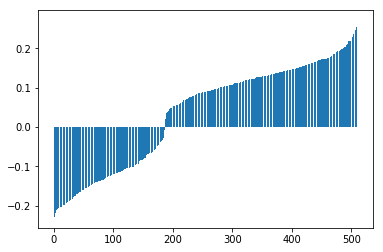

In [30]:
w = head_model.layers[-1].get_weights()[0]
w = w.flatten().tolist()
w = sorted(w)
fig, axes = plt.subplots(1,1)
axes.bar(range(len(w)), w)
plt.show()

In [31]:
_, _, tmp_model = build_model(64e-5,0, activation='linear')
tmp_model.set_weights(head_model.get_weights())

In [32]:
a = np.ones((21*21,512),dtype=K.floatx())
b = np.ones((21*21,512),dtype=K.floatx())
for i in range(21):
    for j in range(21):
        a[21*i + j] *= float(i)/10.0
        b[21*i + j] *= float(j)/10.0
x    = np.arange(0.0, 2.01, 0.1, dtype=K.floatx())
x, y = np.meshgrid(x, x)
z    = tmp_model.predict([a,b], verbose=0).reshape((21,21))
x.shape, y.shape, z.shape

((21, 21), (21, 21), (21, 21))

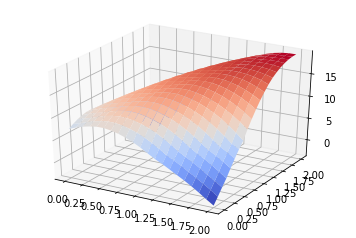

In [33]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap=cm.coolwarm)
plt.show()

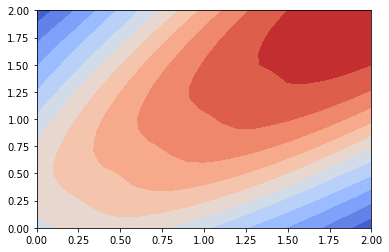

In [34]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())
fig = plt.figure()
ax = fig.add_subplot(111)
cf = ax.contourf(x, y, z, levels=levels, cmap=cm.coolwarm)
plt.show()

A Jupyter Widget

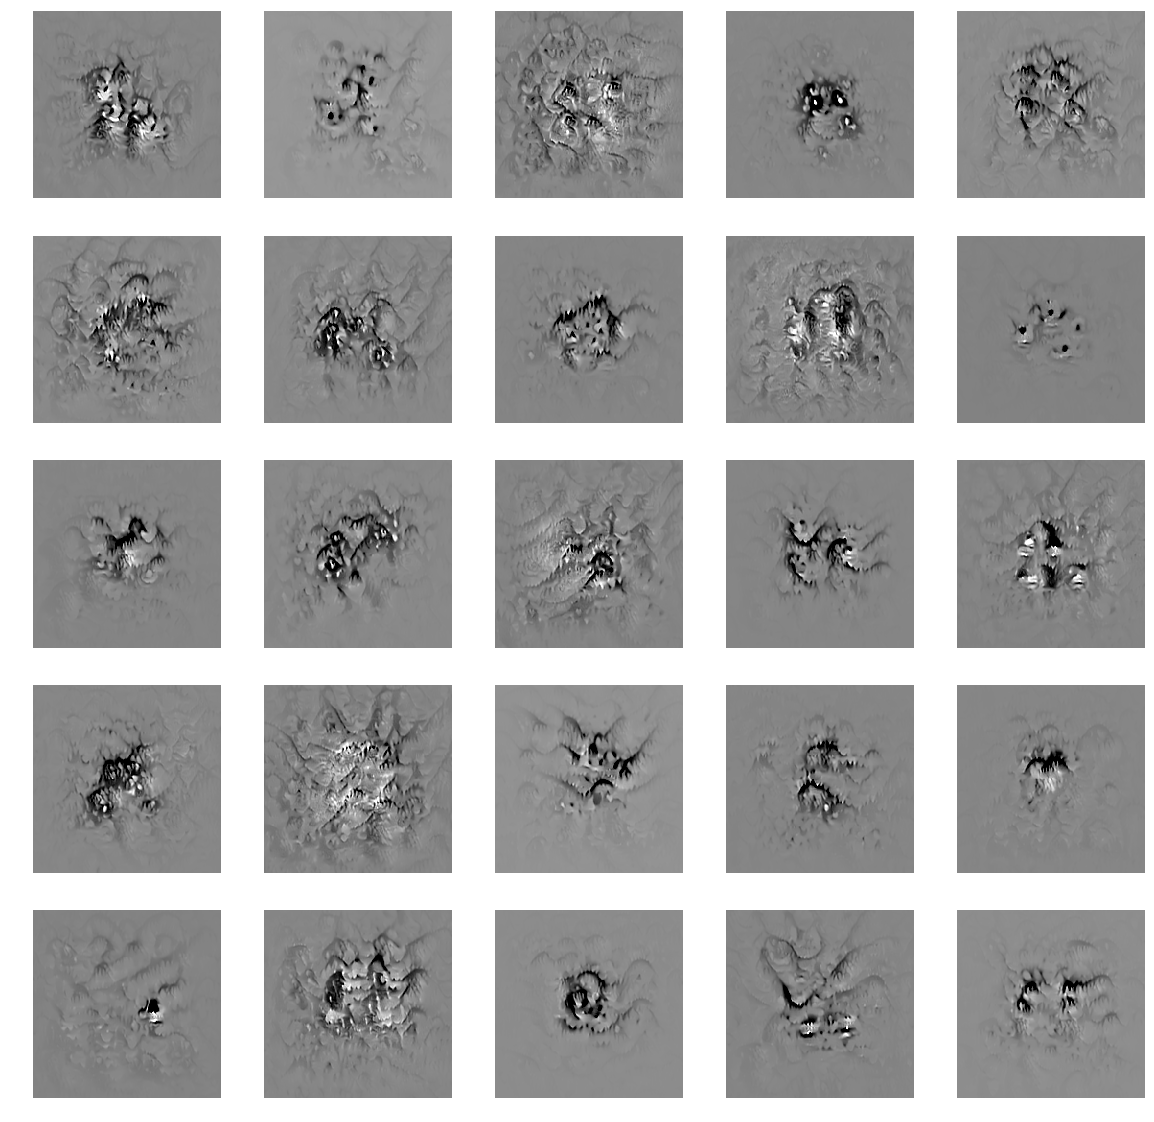

In [35]:
from scipy.ndimage import gaussian_filter

def show_filter(filter, blur):
    np.random.seed(1)
    noise   = 0.1 
    step    = 1 
    
    inp     = branch_model.layers[0].get_input_at(0)
    loss    = K.mean(branch_model.layers[-3].output[0,2:4,2:4,filter]) 
    grads   = K.gradients(loss, inp)[0]
    grads  /= K.sqrt(K.mean(K.square(grads))) + K.epsilon()
    iterate = K.function([inp],[grads])
    img     = (np.random.random(img_shape) -0.5)*noise
    img     = np.expand_dims(img, 0)

    for i in range(200):
        grads_value = iterate([img])[0]
        img = gaussian_filter(img + grads_value*step, sigma=blur)

    avg  = np.mean(img)
    std  = sqrt(np.mean((img - avg)**2))
    low  = avg - 5*std
    high = avg + 5*std
    return array_to_img(np.minimum(high, np.maximum(low, img))[0])

show_whale([show_filter(i, 0.5) for i in tqdm_notebook(range(25))], per_row=5)

## Interesting results and scores
Score | Description
---:|-------
0.786 | best score obtained by a linear combination of the standard model with the bootstrap model
0.774 | bootstrapped model
0.766 | standard model
0.752 | VGG like CNN, trained like standard model
0.728 | standard model without L2 regularization (result after 250 epochs)
0.714 | standard model without exclusion list, rotation list and bounding box model (i.e. no manual judgement on the training set)
0.423 | duplicate images and new_whale submission
0.325 | new_whale submission
0.107 | duplicate images only
